# **Part 1: Data Exploration**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from google.colab import files
import io

### Load dataset and view random samples

In [2]:
uploaded = files.upload()
df_iris = pd.read_csv(io.BytesIO(uploaded['iris_dataset_missing.csv']))

Saving iris_dataset_missing.csv to iris_dataset_missing.csv


In [3]:
df_iris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
73,6.387364,3.146142,5.184828,2.277872,Iris-virginica
49,5.603065,2.472338,4.955694,2.052568,Iris-virginica
69,6.494101,2.703528,4.584629,1.581322,Iris-versicolor
71,7.795561,2.643068,6.768611,2.424502,Iris-virginica
66,5.567296,2.850709,4.948188,2.066787,Iris-virginica


## **Pair Plots**
Generate a “pairs plot” (also called a scatter plot matrix) of the data. From the pair plot, identify the subplots corresponding to the pairs of features where correlation is seen.

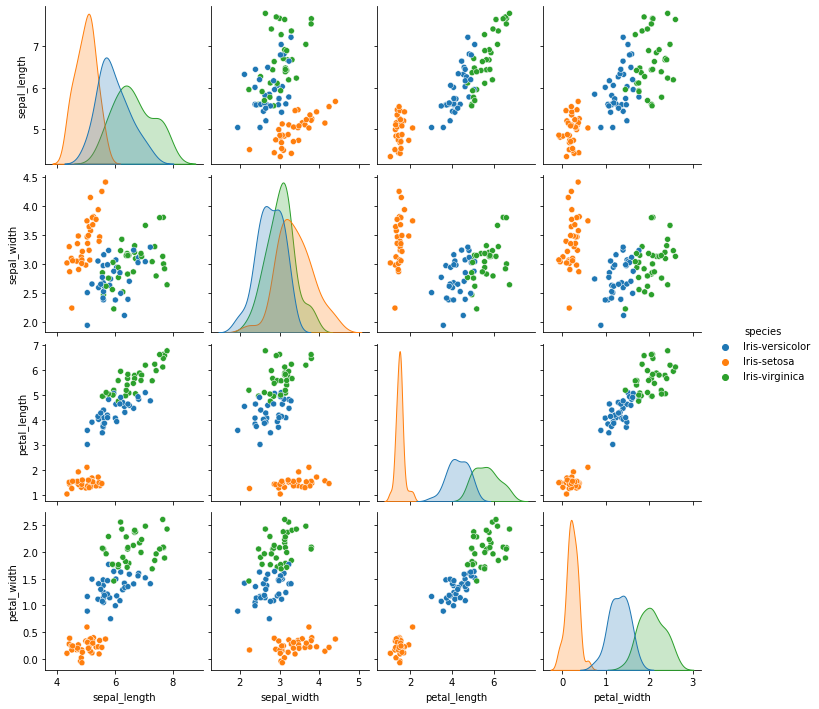

In [4]:
seaborn.pairplot(df_iris, hue="species")
plt.show()

### Comments:
- Petal length and petal width are correlated.
- Samples with small petal length and small petal width are most probably Iris-Setosa.
- Samples with medium petal length and medium petal width are most probably Iris-Versicolor.
- Samples with large petal length and large petal width are most probably Iris-Virginica.

## **Correlation Coefficient**
Calculate and report the correlation coefficient for the pair of features.

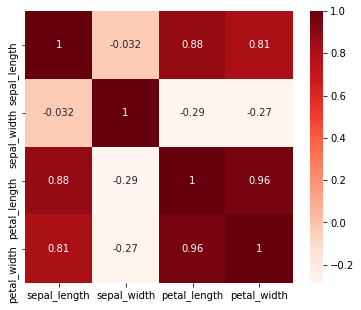

In [5]:
df_iris_features = df_iris[df_iris.columns[:-1]]
cor = df_iris_features.corr()
plt.figure(figsize=(6,5))
seaborn.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Comments:
 - High positive correlation between Petal Width and Petal Length (0.96)
 - High positive correlation between Petal Length and Sepal Length (0.88)
 - High positive correlation between Petal Width and Sepal Length (0.81)
 - Sepal Width has a negligible correlation with other features

## **Moments and Boxplots**

Calculate the mean, variance, skew, kurtosis for the datasets and observe the nature of data and the relationships between the features of the dataset.

Detect the presence of outliers

In [6]:
stats = df_iris_features.describe()
stats.loc['var'] = df_iris_features.var().tolist()
stats.loc['skew'] = df_iris_features.skew().tolist()
stats.loc['kurt'] = df_iris_features.kurtosis().tolist()
print(stats)

       sepal_length  sepal_width  petal_length  petal_width
count    105.000000   101.000000     97.000000   105.000000
mean       5.858909     3.059083      3.812370     1.199708
std        0.861638     0.455116      1.793489     0.787193
min        4.344007     1.946010      1.033031    -0.072203
25%        5.159145     2.768688      1.545136     0.333494
50%        5.736104     3.049459      4.276817     1.331797
75%        6.435413     3.290318      5.094427     1.817211
max        7.795561     4.409565      6.768611     2.603123
var        0.742420     0.207131      3.216602     0.619672
skew       0.401506     0.367708     -0.255767    -0.074751
kurt      -0.544820     0.510490     -1.389810    -1.315451


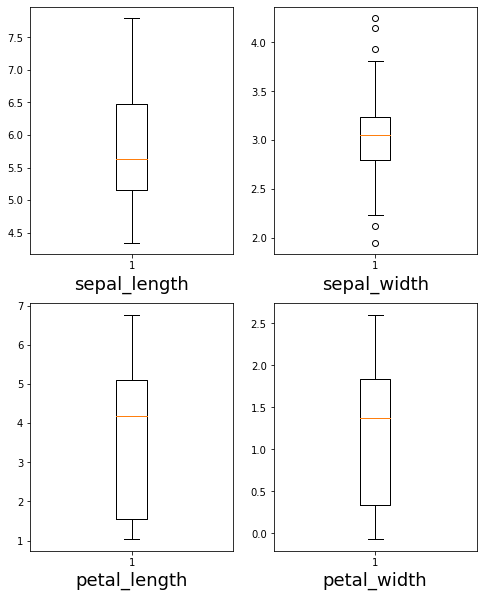

In [7]:
width = 4
height = 5
medianfill_iris = df_iris.dropna()
plt.figure(figsize=(width*2,height*2))

for i, column in enumerate(medianfill_iris.columns[:-1], 1):
    plt.subplot(2,2,i)
    plt.boxplot(medianfill_iris[column])
    plt.xlabel(column, fontsize=18)

### Comments:
- From "min" we can see that "petal_width" has negative values (should be removed during data cleaning)
- From count, seems that some columns have missing values, will be removed in data cleaning.
- From box plot "sepal_width" has 5 outliers, will be removed during data cleaning

## **Data Cleaning**
Deal with any missing values in the data and remove any noise from the data by applying smoothing on some features. 

In [22]:
# Remove -ve values from "petal_width"
nonegative_iris = df_iris.drop(df_iris[df_iris['petal_width'] < 0].index)

# check for missing values
print("Missing values before removal:\n{}".format(nonegative_iris.isnull().sum()))

# Remove rows with missing values
subs_iris = nonegative_iris.dropna()

# Check for missing values after removal
print("\nMissing values after removing NaNs:\n{}".format(subs_iris.isnull().sum()))

# Remove outliers using IQR
Q1 = subs_iris.quantile(0.25)
Q3 = subs_iris.quantile(0.75)
IQR = Q3 - Q1
df_iris_clean = subs_iris[~((subs_iris < (Q1 - 1.5 * IQR)) |(subs_iris> (Q3 + 1.5 * IQR))).any(axis=1)]

# Chack data frame size before and after cleaning
print("\nShape:")
print("Raw dataset before any cleaning:\n{}".format(df_iris.shape))
print("Dataset after removing NaN and negative values:\n{}".format(subs_iris.shape))
print("Clean dataset after removing outliers:\n{}".format(df_iris_clean.shape))

Missing values before removal:
sepal_length    0
sepal_width     4
petal_length    8
petal_width     0
species         0
dtype: int64

Missing values after removing NaNs:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Shape:
Raw dataset before any cleaning:
(105, 5)
Dataset after removing NaN and negative values:
(91, 5)
Clean dataset after removing outliers:
(88, 5)


### Applied cleaning for Iris dataset
 - Remove -ve values from "petal_width"
 - Remove rows with missing values
 - Remove outliers using IQR

# **Part 2: KNN Classifier**
## **Basic Model:**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [10]:
k = [1, 5, 10, 15, 20, 25, 30, 35]

In [23]:
df_iris_knn = df_iris_clean

Divide the data into train, validation, and test sets (60%, 20%, 20%), set the random seed for splitting, use random state=275.

In [12]:
train, set_ = train_test_split(df_iris_knn, test_size=0.4, random_state=275)
validate, test = train_test_split(set_, test_size=0.5, random_state=275)

x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
x_validate, y_validate = validate[validate.columns[:-1]], validate[validate.columns[-1]]
x_test, y_test = test[test.columns[:-1]], test[test.columns[-1]]

Train the model with the classifier’s default parameters. Use the train set and test the model on the test set. Store the accuracy of the model.

In [13]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)
accuracy_iris_default = metrics.accuracy_score(y_test, prediction)
print("Default: accuracy =",accuracy_iris_default)

Default: accuracy = 0.8888888888888888


Find the best parameters for the classifier:
- Test the following values of k for validation k: {1, 5, 10, 15, 20, 25, 30, 35}.
- Fit the model using the train set.
- Test the model with the validation set. Store the accuracy.
- Plot a figure that shows the validation relationship between the accuracy and the parameter.
- Report the best k in terms of classification accuracy.

In [14]:
accuracy_iris = []

for i in range(len(k)):
  knn = KNeighborsClassifier(n_neighbors=k[i])
  knn.fit(x_train, y_train)
  prediction = knn.predict(x_validate)
  accuracy_iris.append(metrics.accuracy_score(y_validate, prediction))
print(accuracy_iris)

[0.9444444444444444, 0.9444444444444444, 0.8888888888888888, 0.9444444444444444, 0.8888888888888888, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666]


Text(0, 0.5, 'accuracy')

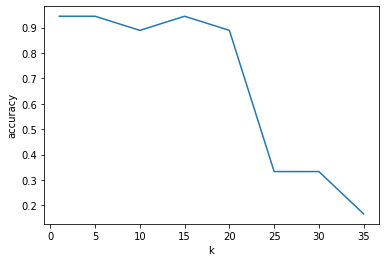

In [15]:
plt.plot(k,accuracy_iris)
plt.xlabel('k')
plt.ylabel('accuracy')

*   Best k: 1, 5, 15



Using the best found parameters, fit the model using the training set and predict the target on the test set.

Report the accuracy, AUC, f-score of the kNN classifier.

In [16]:
k_best = [1,5,15]

train, set_ = train_test_split(df_iris_knn, test_size=0.4, random_state=275)
validate, test = train_test_split(set_, test_size=0.5, random_state=275)

x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
x_validate, y_validate = validate[validate.columns[:-1]], validate[validate.columns[-1]]
x_test, y_test = test[test.columns[:-1]], test[test.columns[-1]]

for i in range(len(k_best)):
  print('k =',k_best[i],':')
  knn = KNeighborsClassifier(n_neighbors=k_best[i])
  knn.fit(x_train, y_train)
  prediction = knn.predict(x_test)
  print('accuracy =',metrics.accuracy_score(y_test, prediction))
  prediction_proba = knn.predict_proba(x_test)
  print('auc      =',metrics.roc_auc_score(y_test, prediction_proba, multi_class='ovo', average='macro'))
  print('f-score  =',metrics.f1_score(y_test, prediction, average='macro'))
  print()

k = 1 :
accuracy = 0.8888888888888888
auc      = 0.9500000000000001
f-score  = 0.8796296296296297

k = 5 :
accuracy = 0.8888888888888888
auc      = 1.0
f-score  = 0.8796296296296297

k = 15 :
accuracy = 0.8888888888888888
auc      = 1.0
f-score  = 0.8796296296296297



## **Improved Model:**
Try to improve the classification results using performance metrics by exploring different ways to improve using the validation set.

**Normalization:**

Z-Score normalization is used to prevent outlier from dominating the min-max normalization, and similar points can be treated the same.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit and transform the data
features = ['sepal_length','sepal_width','petal_length','petal_width']
df_iris_knn[features] = scaler.fit_transform(df_iris_knn[features])

In [25]:
df_iris_knn.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
28,1.273423,-0.000450,0.661468,0.322036,Iris-versicolor
1,0.464294,-2.329575,0.351503,0.192076,Iris-versicolor
90,0.291066,-0.478709,0.406447,-0.231797,Iris-versicolor
78,0.810956,-0.442742,0.869165,1.108752,Iris-virginica
79,-0.987601,1.762359,-1.016812,-0.871001,Iris-setosa


**Weighted KNN:**

Use different weighting schemes (default, manhatten, eculidean) to see the effect.

In [18]:
train, set_ = train_test_split(df_iris_knn, test_size=0.4, random_state=275)
validate, test = train_test_split(set_, test_size=0.5, random_state=275)

x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
x_validate, y_validate = validate[validate.columns[:-1]], validate[validate.columns[-1]]
x_test, y_test = test[test.columns[:-1]], test[test.columns[-1]]

In [19]:
accuracy_iris_default = []
for i in range(len(k)):
  knn = KNeighborsClassifier(n_neighbors=k[i], weights='distance')
  knn.fit(x_train, y_train)
  prediction = knn.predict(x_validate)
  accuracy_iris_default.append(metrics.accuracy_score(y_validate, prediction))
print('Default:', accuracy_iris_default)

accuracy_iris_manhatten = []
for i in range(len(k)):
  knn = KNeighborsClassifier(n_neighbors=k[i], metric='manhattan', weights='distance')
  knn.fit(x_train, y_train)
  prediction = knn.predict(x_validate)
  accuracy_iris_manhatten.append(metrics.accuracy_score(y_validate, prediction))
print('Manhatten:', accuracy_iris_manhatten)

accuracy_iris_euclidean = []
for i in range(len(k)):
  knn = KNeighborsClassifier(n_neighbors=k[i], metric='euclidean', weights='distance')
  knn.fit(x_train, y_train)
  prediction = knn.predict(x_validate)
  accuracy_iris_euclidean.append(metrics.accuracy_score(y_validate, prediction))
print('Euclidean:', accuracy_iris_euclidean)

Default: [0.8888888888888888, 1.0, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]
Manhatten: [0.8888888888888888, 1.0, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]
Euclidean: [0.8888888888888888, 1.0, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]


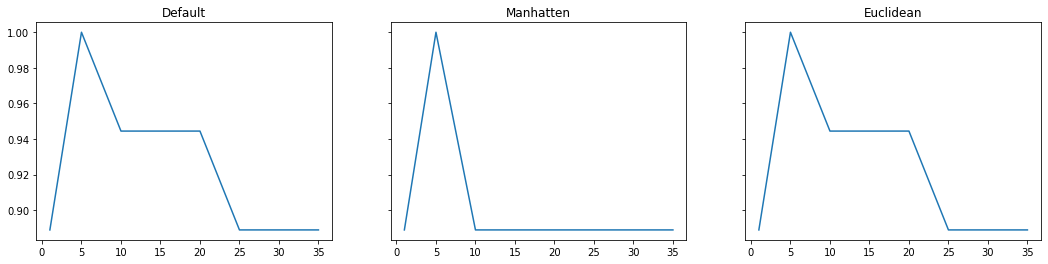

In [20]:
width = 6
height = 4
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(width*3,height))
ax1.plot(k,accuracy_iris_default)
ax1.set_title('Default')
ax2.plot(k,accuracy_iris_manhatten)
ax2.set_title('Manhatten')
ax3.plot(k,accuracy_iris_euclidean)
ax3.set_title('Euclidean')
plt.show()

*   Best metric: Default, Euclidean
*   Best k: 5



Compute the new classification results on the test set and report the accuracy, AUC and f-score.

In [21]:
# Choose Euclidean
k_best = [5]

train, set_ = train_test_split(df_iris_knn, test_size=0.4, random_state=275)
validate, test = train_test_split(set_, test_size=0.5, random_state=275)

x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
x_validate, y_validate = validate[validate.columns[:-1]], validate[validate.columns[-1]]
x_test, y_test = test[test.columns[:-1]], test[test.columns[-1]]

for i in range(len(k_best)):
  print('k =',k_best[i],':')
  knn = KNeighborsClassifier(n_neighbors=k_best[i], metric='euclidean', weights='distance')
  knn.fit(x_train, y_train)
  prediction = knn.predict(x_test)
  print('accuracy =',metrics.accuracy_score(y_test, prediction))
  prediction_proba = knn.predict_proba(x_test)
  print('auc      =',metrics.roc_auc_score(y_test, prediction_proba, multi_class='ovo', average='macro'))
  print('f-score  =',metrics.f1_score(y_test, prediction, average='macro'))
  print()

k = 5 :
accuracy = 0.8333333333333334
auc      = 0.975
f-score  = 0.8300653594771242



**Basic Model:**
*   k = 5
*   accuracy = 0.8888888888888888
*   auc      = 1.0
*   f-score  = 0.8796296296296297

**Improved Model:**
*   k = 5
*   normalization: Z-score
*   knn metric: Euclidean
*   accuracy = 0.8333333333333334
*   auc      = 0.975
*   f-score  = 0.8300653594771242